In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
import access_era_5 as access_era_5
from statsmodels.tsa.stattools import adfuller
import sys, os
sys.path.append(os.path.abspath(".."))

from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="arimaEra5.log", nome_classe="Arima Era5")
logger.info("Iniciando a execução do script Arima com dataset Era 5.")

2025-09-29 22:05:08,679 - Arima Era5 - INFO - Iniciando a execução do script Arima com dataset Era 5.


/home/pbose/tcc/pesquisa/era5/access_era_5.py:9: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(caminho_completo, chunks={"valid_time": 100})
2025-09-29 22:05:10,359 - Arima Era5 - INFO - Dados carregados com sucesso. Total de 366 registros.
2025-09-29 22:05:10,360 - Arima Era5 - INFO - Dados divididos em treino (219 registros) e teste (147 registros).


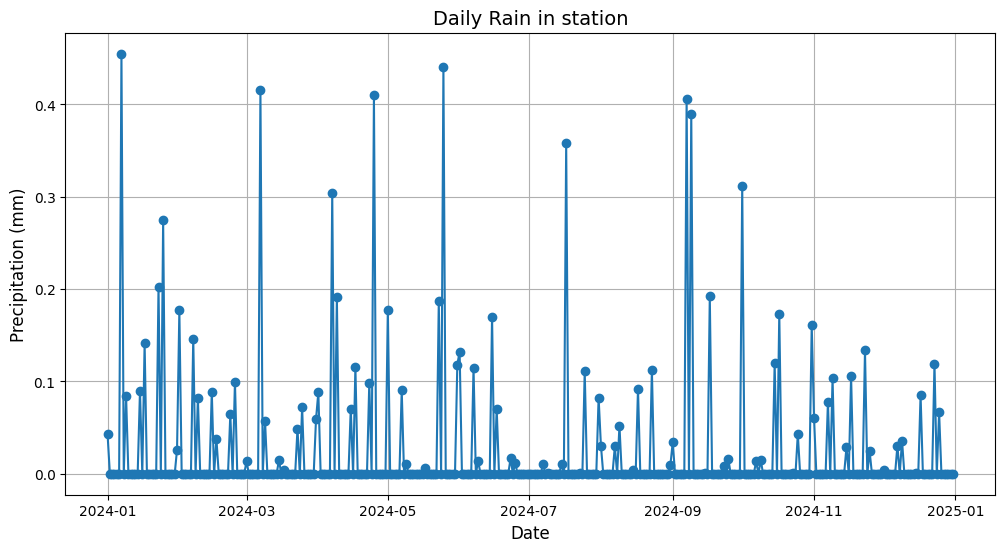

In [2]:
timeseries = access_era_5.recuperar_dados_era_5()
logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
dias = timeseries['valid_time']
total_chuva = timeseries['tp']
train_size = int(len(total_chuva) * 0.60)
test_size = len(total_chuva) - train_size
train, test = total_chuva[:train_size], total_chuva[train_size:]
logger.info(f"Dados divididos em treino ({len(train)} registros) e teste ({len(test)} registros).")
dias = pd.to_datetime(dias)

# Faz o plot
plt.figure(figsize=(12,6))
plt.plot(dias, total_chuva, marker="o", linestyle="-")

plt.title("Daily Rain in station", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True)
plt.show()


In [3]:
logger.info("Executando teste Augmented Dickey-Fuller (ADF) para estacionariedade.")
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
logger.info(f"Resultado do ADF - p-valor: {adfuller(timeseries['tp'], autolag='AIC')[1]}. A série parece ser estacionária.")

2025-09-29 22:05:10,479 - Arima Era5 - INFO - Executando teste Augmented Dickey-Fuller (ADF) para estacionariedade.
2025-09-29 22:05:10,495 - Arima Era5 - INFO - Resultado do ADF - p-valor: 2.993685589237761e-13. A série parece ser estacionária.


2025-09-29 22:05:10,501 - Arima Era5 - INFO - Gerando gráficos ACF e PACF para análise de lags.


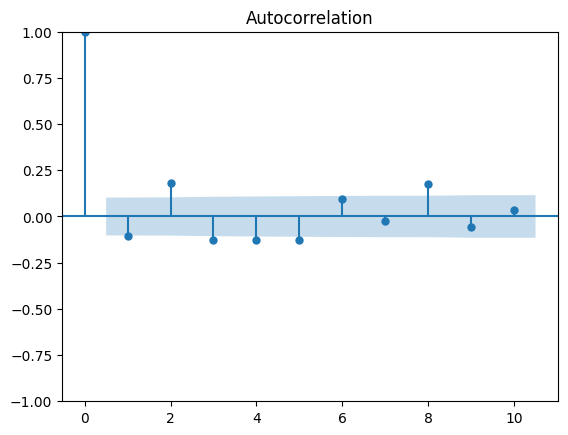

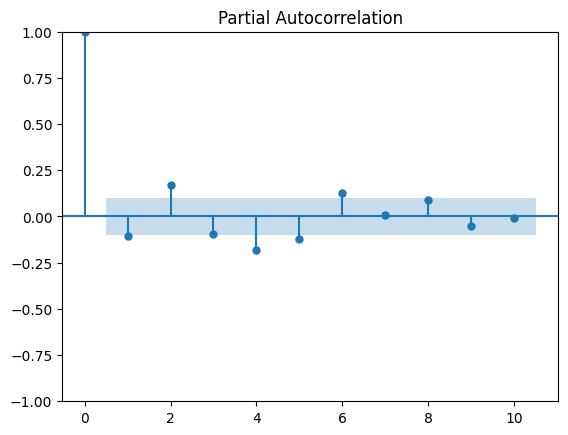

In [4]:
logger.info("Gerando gráficos ACF e PACF para análise de lags.")
plot_acf(timeseries['tp'], lags=10)
plot_pacf(timeseries['tp'], lags=10)
plt.show()

In [ ]:
#ARIMA AUTO
p, d, q = 2, 1 , 1
logger.info(f"Treinando o modelo ARIMA com ordem ( {p} , {d} , {q})")
model = ARIMA(train, order=(p, d, q))
model = model.fit()
test_forecast = model.forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.values, index=test.index)


# RMSE
rmse = sqrt(mean_squared_error(test, test_forecast))
print('RMSE:', rmse)

# MSE
mse = mean_squared_error(test, test_forecast)
print('MSE:', mse)

# MAE
mae = mean_absolute_error(test, test_forecast)
print('MAE:', mae)
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")



TypeError: can only concatenate str (not "int") to str

In [ ]:

# Plot
logger.info("Gerando gráfico de avaliação final do modelo ARIMA.")
plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')

plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('mm')
plt.legend()
plt.show()
logger.info("Execução do script ARIMA ERA5 finalizada.")